In [1]:
import numpy as np
import sys
import time
import h5py as h5
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from scipy.stats import linregress

sys.path.append(r"C:\Users\haoyuan\Documents\GitHub\CrystalDiff")

from CrystalDiff import util, pulse, lclsutil, crystal, lightpath

# Prepare the crystal

In [2]:
# ----------------------------------------------------------------------------------------------------------
#                       Step 1: Pulse
# ----------------------------------------------------------------------------------------------------------
energy_center = 10.
pre_length = 1e6

# Set up the pulse
my_pulse = pulse.GaussianPulse3D()
my_pulse.set_pulse_properties(central_energy=energy_center,
                              polar=[0., 1., 0.],
                              sigma_x=708.2581446128465,
                              sigma_y=708.2581446128465,
                              sigma_z=1.,
                              x0=np.array([0., 0., -pre_length]))

# ----------------------------------------------------------------------------------------------------------
#                       Step 2: Split
# ----------------------------------------------------------------------------------------------------------
dtheta = np.arctan(1.5 * 1e-3 / 5.)  # This is the deviation angle.
half_period = util.get_grating_period(dtheta=dtheta,
                                      klen_in=my_pulse.klen0) / 2

grating_list = [crystal.RectangleGrating(), crystal.RectangleGrating()]
grating_list[0].set_a(half_period)
grating_list[0].set_b(half_period)
grating_list[1].set_a(half_period)
grating_list[1].set_b(half_period)

# ----------------------------------------------------------------------------------------------------------
#                       Step 3: Delay Lines
# ----------------------------------------------------------------------------------------------------------
# Some meta data for the delay line.
h_length = 2. * np.pi / (1.9201 * 1e-4)

# Some crystal properties
chi0 = complex(-0.97631E-05, 0.14871E-06)
chih_sigma = complex(0.59310E-05, -0.14320E-06)
chihbar_sigma = complex(0.59310E-05, -0.14320E-06)
chih_pi = complex(0.46945E-05, -0.11201E-06)
chihbar_pi = complex(0.46945E-05, -0.11201E-06)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal for branch  1
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset_1 = dtheta

# Bragg angle
bragg = np.radians(18.836) + 13e-6
miscut = np.deg2rad(10.)

# Get crystal angles
eta_b1 = np.zeros(6, dtype=np.float64)
theta_b1 = np.array([np.pi / 2. + bragg,
                     3 * np.pi / 2. + bragg,
                     3 * np.pi / 2. - bragg,
                     np.pi / 2. - bragg,
                     3 * np.pi / 2. - bragg,
                     np.pi / 2. - bragg])
rho_b1 = theta_b1 + np.pi
tau_b1 = np.array([0., miscut, 0, miscut,
                   -miscut, -miscut])

# Add the effect of the global rotation due to the grating momentum transfer
theta_b1 += angle_offset_1
rho_b1 += angle_offset_1

# Initialize the crystals
crystal_list_1 = lclsutil.get_crystal_list(num=6,
                                           hlen=np.array([h_length, ] * 6),
                                           theta=theta_b1,
                                           eta=eta_b1,
                                           rho=rho_b1,
                                           tau=tau_b1,
                                           chi0=chi0,
                                           chih_sigma=chih_sigma,
                                           chihbar_sigma=chihbar_sigma,
                                           chih_pi=chih_pi,
                                           chihbar_pi=chihbar_pi)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal for branch  2
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset_2 = - dtheta
bragg = np.radians(18.836) + 13e-6

# Get crystal angles
eta_b2 = np.zeros(4, dtype=np.float64)
theta_b2 = np.array([3 * np.pi / 2. - bragg,
                     np.pi / 2. - bragg,
                     np.pi / 2. + bragg,
                     3 * np.pi / 2. + bragg])
rho_b2 = theta_b2 + np.pi
tau_b2 = np.zeros(4, dtype=np.float64)

# Add the effect of the global rotation due to the grating momentum transfer
theta_b2 += angle_offset_2
rho_b2 += angle_offset_2

# Initialize the crystals
crystal_list_2 = lclsutil.get_crystal_list(num=4,
                                           hlen=np.array([h_length, ] * 4),
                                           theta=theta_b2,
                                           eta=eta_b2,
                                           rho=rho_b2,
                                           tau=tau_b2,
                                           chi0=chi0,
                                           chih_sigma=chih_sigma,
                                           chihbar_sigma=chihbar_sigma,
                                           chih_pi=chih_pi,
                                           chihbar_pi=chihbar_pi)

# ------------------------------------------------------
#   Define the positions
# ------------------------------------------------------
path_list_fix = [5e6, 1e5, 2e5, 1.05e5, 6e6, 1e6]
path_list_var = [5e6- 2e5, 1e5, 4e5, 2e4, 3e5, 8.5e4, 6e6 - 1476244.1148770414, 1e6]
delay_time = 100

In [3]:
for x in crystal_list_1:
    print(x.h)

[     0.          30967.47072397 -10574.725901  ]
[     0.         -30967.47072397  10574.725901  ]
[     0.         -30973.8099848  -10556.14351679]
[    0.         30973.8099848  10556.14351679]
[     0.         -30973.8099848  -10556.14351679]
[    0.         30973.8099848  10556.14351679]


In [4]:
for x in crystal_list_1:
    print(x.normal)

[ 0.         -0.94634549  0.32315665]
[ 0.17364818  0.93196837 -0.31824718]
[0.         0.94653921 0.32258879]
[ 0.17364818 -0.93215915 -0.31768794]
[-0.17364818  0.93215915  0.31768794]
[-0.17364818 -0.93215915 -0.31768794]


# Adjust the crystals

In [5]:
# ---------------------------------------------------------------------------
#                  Adjust the position of the crystals
# ---------------------------------------------------------------------------

(fix_branch_path,
 kout_fixed,
 intersect_fixed,
 var_branch_path,
 kout_var,
 intersect_var) = lightpath.adjust_path_length(delay_time=delay_time,
                                               fix_branch_path=path_list_fix,
                                               fix_branch_crystal=crystal_list_2,
                                               var_branch_path=path_list_var,
                                               var_branch_crystal=crystal_list_1,
                                               grating_pair=grating_list,
                                               kin=my_pulse.k0)

# -----------------------------------------------------------------------------
#                 Update the crystals
# -----------------------------------------------------------------------------
crystal_list_1 = lclsutil.update_crystal_list(crystal_list_1,
                                              surface_points=np.copy(intersect_var[1:-2]))
crystal_list_2 = lclsutil.update_crystal_list(crystal_list_2,
                                              surface_points=np.copy(intersect_fixed[1:-2]))
grating_list[0].set_surface_point(np.copy(intersect_fixed[0]))
grating_list[1].set_surface_point(np.copy(intersect_fixed[-2]))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Get the observation point
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
observation = np.copy(intersect_fixed[-1]) 
total_path = pre_length + np.sum(fix_branch_path)

print("The total propagation length is {:.2f}m.".format(total_path / 1e6))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                  Change frame
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
(my_pulse,
 observation,
 [crystal_list_1, 
  crystal_list_2,
  grating_list]
) = lclsutil.get_output_frame(displacement=-np.copy(intersect_fixed[-1]),
                              observe=observation,
                              pulse=my_pulse,
                              crystal_lists = [crystal_list_1, 
                                               crystal_list_2,
                                               grating_list])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                  Get the momentum mesh
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
number_x = 2
number_y = 250
number_z = 10 ** 5
kx_grid, ky_grid, kz_grid, axis_info = util.get_k_mesh_3d(number_x=number_x,
                                                          number_y=number_y,
                                                          number_z=number_z,
                                                          delta_e_x=1e-50,
                                                          delta_e_y=1e-4,
                                                          delta_e_z=1e-3 / util.c)
kz_grid += my_pulse.klen0

# Apply fft shift
# kx_grid = np.ascontiguousarray(np.fft.fftshift(kx_grid))
kx_grid = np.zeros(1, np.float64)
number_x = 1
ky_grid = np.ascontiguousarray(np.fft.fftshift(ky_grid))
kz_grid = np.ascontiguousarray(np.fft.fftshift(kz_grid))

The total propagation length is 12.23m.


In [6]:
for x in crystal_list_1:
    print(x.normal)

[ 0.         -0.94634549  0.32315665]
[ 0.17364818  0.93196837 -0.31824718]
[0.         0.94653921 0.32258879]
[ 0.17364818 -0.93215915 -0.31768794]
[-0.17364818  0.93215915  0.31768794]
[-0.17364818 -0.93215915 -0.31768794]


# Calculate the instability spacial case

In [7]:
kout = np.copy(kout_var[1])
print(kout)

a = 1e-5
b = 1e-5
c = -1e-5
misalign = [np.array([a, b, c]),
           np.array([a, b, c]),
           np.array([a, b, c]),
           np.array([a, b, c]),
           np.zeros(3),
           np.zeros(3)]


for x in range(6):
    
    rot_mat = Rotation.from_euler('xyz',misalign[x], degrees=False)
    matrix = rot_mat.as_dcm()
    
    kout, ratio = util.get_bragg_kout(kin= kout,
                                      h= matrix.dot(crystal_list_1[x].h),
                                      normal= matrix.dot(crystal_list_1[x].normal),
                                      compare_length=True)
    
    print(kout, ratio)

print(kout - grating_list[1].base_wave_vector)
print((kout - grating_list[1].base_wave_vector) / my_pulse.klen0)

[0.00000000e+00 1.52031923e+01 5.06773076e+04]
[2.03934498e-01 3.09832194e+04 4.01027412e+04] 0.9999999999999999
[-8.19268073e-02  1.52031957e+01  5.06773076e+04] 1.0
[-4.97258630e-01 -3.09607570e+04  4.01200855e+04] 1.0
[-5.02139174e-01  1.52031805e+01  5.06773076e+04] 1.0
[-2.51070545e-01 -3.09599546e+04  4.01207047e+04] 1.0
[-5.58630927e-07  1.52031878e+01  5.06773076e+04] 1.0000000000000002
[-5.58630927e-07 -4.51029402e-06  5.06773076e+04]
[-1.10232953e-11 -8.90002692e-11  1.00000000e+00]


# Calculate the instability coefficient

In [8]:
# In this simulation, I would like to study the derivation across 10 urad variation.
# The num is the number of partitions I divide the 10 urad into.
num = 100
num_total = 2 * num + 1

kout_holder = np.zeros((3, num_total, 3), dtype=np.float64)

for a_idx in range(3):  # The axis index

    eular_list = np.zeros((num_total, 3), dtype = np.float64)
    eular_list[:, a_idx] = np.arange(-num, num + 1) * 1e-5 / num

    for idx in range(num_total):

        # Define rotation matrix
        rot_mat = Rotation.from_euler('xyz', eular_list[idx], degrees=False)
        matrix = rot_mat.as_dcm()

        # Get the kout
        kout = np.copy(kout_var[1])

        for x in range(4):
            kout, ratio = util.get_bragg_kout(kin=kout, 
                                              h = np.dot(matrix, crystal_list_1[x].h),
                                              normal= np.dot(matrix, crystal_list_1[x].normal),
                                              compare_length=True)

        for x in range(4, 6):
            kout, ratio = util.get_bragg_kout(kin=kout, 
                                              h = crystal_list_1[x].h,
                                              normal= crystal_list_1[x].normal,
                                              compare_length=True)

        kout_holder[:, idx, a_idx] = kout - grating_list[1].base_wave_vector


In [9]:
kout_diff = kout_holder - kout_var[-1][:, np.newaxis, np.newaxis]

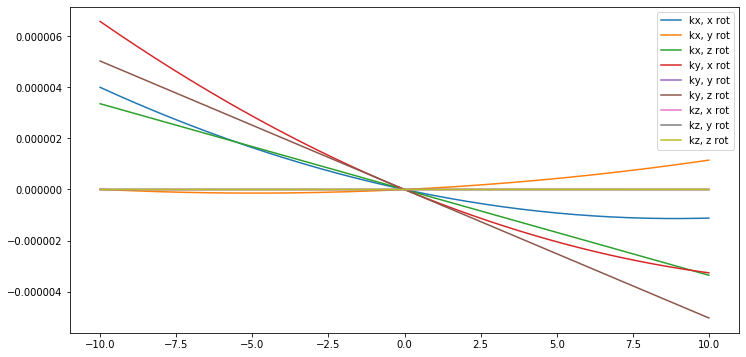

In [10]:
axis = ['x', 'y', 'z']
momen = ['kx', 'ky', 'kz']

plt.figure(figsize=(12,6))

for x in range(3):
    for y in range(3):
        plt.plot(np.arange(-100, 101) / 10., kout_diff[x, :, y], label="{}, {} rot".format(momen[x],
                                                                                           axis[y]))
        
plt.legend()
plt.show()

In [11]:
gradient_holder = np.zeros((3, 3))

angles = np.arange(-100, 101) / 10.  # urad

for x in range(3):
    for y in range(3):
        
        # Slope through the origin
        slope_o = np.dot(angles, kout_diff[x, :, y]) / np.dot(angles, angles)
        
        # Save the gradient
        gradient_holder[x, y] = slope_o

# Deviation angle for 10 urad misalignment

In [12]:
print(np.arctan(gradient_holder * 10 / my_pulse.klen0))

[[-5.04151132e-11  1.12615435e-11 -6.61462730e-11]
 [-9.69386135e-11 -3.04513021e-14 -9.90863350e-11]
 [ 2.90823514e-14  1.07781485e-17  2.97204687e-14]]
